# Capstone Project - Reducing travel time
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

At present, Bogotá lives one of the worst vehicle congestion in its history (https://www.bbc.com/mundo/noticias-39045803), this can be verified according to an article from the BBC world, based on this problem we intend to perform a market study to find the best place to establish a business (in this exercise we will install a cafeteria) and at the same time find a place of residence within the selected locality, in order to make viable the undertaking of a new business and reduce the time of displacement between these two places.

Target audiences

This project is intended for that entrepreneurial population or who want to be independent, who wants to have a good location between business and housing to reduce travel times and thus greatly improve their quality of life.

## Data <a name="data"></a>

According to the definition of our problem, the factors that will influence our decision are:

• Concentration of commercial establishments in neighborhoods.

• Types of commercial establishments that do not compete with ours.

• Areas that stand out for their residential environment.

• Distance between the housing location and the commercial location.

The following data sources will be needed to extract and generate the required information.

• Geo-coded locations of the neighborhoods in the city of Bogotá extracted from the Bogotá Urban Laboratory (https://bogota-laburbano.opendatasoft.com/explore/dataset/barrios_prueba/table/).

• Number of commercial establishments, type and location, which will be obtained from the Foursquare API.

• Distance from residential and commercial areas that will be checked between the data sources of Laboratorio Urbano Bogotá and the Foursquare API.


### Load ibraries

In [1]:
import pandas as pd
import numpy as np

import altair as alt

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import folium # map rendering library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geocoder # import geocoder
from vincenty import vincenty_inverse # Library for calculate distance into two geo points 


## Explore data

In [2]:
#df = pd.read_csv('/Users/oxanderv/Documents/GitHub/Coursera_Capstone/data/barrios_bogota.csv', sep=';')  # call file in ac
df = pd.read_csv('C:\\Users\\orinconv\\Documents\\GitHub\\Coursera_Capstone\\data\\barrios_bogota.csv', sep=';') # call file in windows
print(df.shape)
df.head()   

(3871, 10)


,OBJECTID,Codigo Localidad,Localidad,Estado,Nombre,Codigo,SHAPE.AREA,SHAPE.LEN,geo_shape,geo_point_2d
0,1430,19,Ciudad Bolívar,LEGALIZADO,Jerusalén La Pradera,190083,2.199423e-05,0.022444,"{""type"": ""Polygon"", ""coordinates"": [[[-74.1599...","4.57170783064, -74.1623352778"
1,1431,19,Ciudad Bolívar,LEGALIZADO,Gibraltar I,190076,7.350520e-07,0.003827,"{""type"": ""Polygon"", ""coordinates"": [[[-74.1409...","4.55942859701, -74.1412673602"
2,1434,19,Ciudad Bolívar,LEGALIZADO,San Francisco La Palmera,190212,7.373517e-07,0.005711,"{""type"": ""Polygon"", ""coordinates"": [[[-74.1438...","4.56057102018, -74.143503033"
3,1437,19,Ciudad Bolívar,LEGALIZADO,La Florida del Sur,190100,1.187800e-06,0.006444,"{""type"": ""Polygon"", ""coordinates"": [[[-74.1388...","4.54954369286, -74.1388429955"
4,1440,19,Ciudad Bolívar,SIN LEGALIZAR,Urb. Villa del Rio Zona Comercial,190285,1.229367e-05,0.016802,"{""type"": ""Polygon"", ""coordinates"": [[[-74.1550...","4.59753400889, -74.152870721"


# Convert the list to dataframe and data cleanup

### We extract the columns that will not be used for our purpose, we maintain the coordinates and the names of both the localities and the neighborhoods.

In [3]:
df = df.drop(['OBJECTID', 'Estado', 'Codigo', 'SHAPE.AREA', 'SHAPE.LEN', 'geo_shape'], axis=1)
print('Antes: ', df.shape)
df = df.dropna(axis=0)
df[df.isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df.head()

Antes:  (3871, 4)


,Codigo Localidad,Localidad,Nombre,geo_point_2d
0,19,Ciudad Bolívar,Jerusalén La Pradera,"4.57170783064, -74.1623352778"
1,19,Ciudad Bolívar,Gibraltar I,"4.55942859701, -74.1412673602"
2,19,Ciudad Bolívar,San Francisco La Palmera,"4.56057102018, -74.143503033"
3,19,Ciudad Bolívar,La Florida del Sur,"4.54954369286, -74.1388429955"
4,19,Ciudad Bolívar,Urb. Villa del Rio Zona Comercial,"4.59753400889, -74.152870721"


### looking at the distribution of neighborhoods within the localities

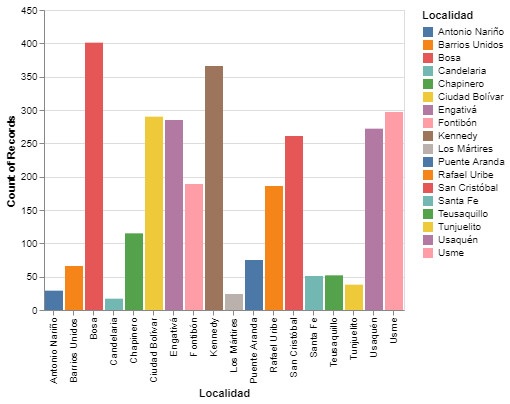

In [4]:
alt.Chart(df).mark_bar().encode(
    x='Localidad',
    y='count(Localidad)',
    color = 'Localidad:N'
)

### For practical reasons and the limitations of the queries that can be made to the Foursquare API we will choose 'Barrios Unidos' for our search, but future users can choose the location that is of interest to them.

We divide the 2d geopoint column between latitude and longitude for easy handling.

In [5]:
df = df[df['Localidad'] == 'Barrios Unidos']
print('Despues: ', df.shape)
df = df.join(df['geo_point_2d'].str.split(',', 1, expand=True).rename(columns={0:'Latitud', 1:'Longitud'}))
df = df.drop(['geo_point_2d'], axis=1)
df.head()


Despues:  (66, 4)


,Codigo Localidad,Localidad,Nombre,Latitud,Longitud
98,12,Barrios Unidos,Siete de Agosto,4.65743849672,-74.0711239929
118,12,Barrios Unidos,La Castellana Occidental,4.68668877287,-74.0628405423
192,12,Barrios Unidos,San Fernando Occidental,4.6745991812,-74.081696473
264,12,Barrios Unidos,11 de Noviembre,4.66829275367,-74.070910549
283,12,Barrios Unidos,12 de Octubre,4.66984252316,-74.0743839871


In [6]:
df_georef = df[['Codigo Localidad', 'Nombre', 'Latitud', 'Longitud']]
df_info = df[['Codigo Localidad', 'Localidad', 'Nombre']]
df_georef['Latitud'] = pd.to_numeric(df_georef['Latitud'])
df_georef['Longitud'] = pd.to_numeric(df_georef['Longitud'])

C:\Users\orinconv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\orinconv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
print('There are {} uniques Names to Neighborhoods.'.format(len(df_info['Nombre'].unique())))

There are 66 uniques Names to Neighborhoods.


In [8]:
group = df_info.groupby(['Codigo Localidad','Nombre'], sort=False).agg(', '.join)
df_group = group.reset_index()
print(df_group.shape)
df_group.head()

(66, 3)


,Codigo Localidad,Nombre,Localidad
0,12,Siete de Agosto,Barrios Unidos
1,12,La Castellana Occidental,Barrios Unidos
2,12,San Fernando Occidental,Barrios Unidos
3,12,11 de Noviembre,Barrios Unidos
4,12,12 de Octubre,Barrios Unidos


# Add coordinates

# Grouped data frame and coordinates

In [67]:
df_bogloc = pd.merge(df_group, df_georef, on='Nombre', how = 'inner')
df_bogloc = df_bogloc.drop(['Codigo Localidad_y'], axis=1)
print(df_bogloc.shape)
df_bogloc.head()

(66, 5)


,Codigo Localidad_x,Nombre,Localidad,Latitud,Longitud
0,12,Siete de Agosto,Barrios Unidos,4.657438,-74.071124
1,12,La Castellana Occidental,Barrios Unidos,4.686689,-74.062841
2,12,San Fernando Occidental,Barrios Unidos,4.674599,-74.081696
3,12,11 de Noviembre,Barrios Unidos,4.668293,-74.070911
4,12,12 de Octubre,Barrios Unidos,4.669843,-74.074384


# Explore the neighborhoods in localitie

In [10]:
address = 'Bogota, CO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogota City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogota City are 4.59808, -74.0760439.


In [11]:
# create map of New York using latitude and longitude values
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_bogloc['Latitud'], df_bogloc['Longitud'], df_bogloc['Localidad'], df_bogloc['Nombre']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)  
    
map_bogota

# Foursquare
### Now that we have our neighborhoods with their respective coordinates, we will call the Foursquare API to obtain the information of each neighborhood.

In [12]:
neighborhood_latitude = df_bogloc.loc[0, 'Latitud'] # neighborhood latitude value
neighborhood_longitude = df_bogloc.loc[0, 'Longitud'] # neighborhood longitude value

neighborhood_name = df_bogloc.loc[0, 'Nombre'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Siete de Agosto are 4.65743849672, -74.0711239929.


In [61]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d6d3af9531593002c57843b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Los Alcázares',
  'headerFullLocation': 'Los Alcázares, Bogotá',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 14,
  'suggestedBounds': {'ne': {'lat': 4.661938501220004,
    'lng': -74.06661750992144},
   'sw': {'lat': 4.652938492219996, 'lng': -74.07563047587855}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57e57681498e56b05cb08864',
       'name': 'Taperia de la plaza',
       'location': {'address': 'Calle 66 22-39',
        'lat': 4.658887,
        'lng': -74.07176,
        'labeledLatLngs': [{'label': 'display',
          'lat': 4.658887,
   

In [68]:
### function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [69]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Taperia de la plaza,Bistro,4.658887,-74.071760
1,Trattoria De La Plaza,Bistro,4.656679,-74.070045
2,Compania del Sabor,Fried Chicken Joint,4.659463,-74.069625
3,Las Plazas De Mercado Siete De Agosto,Market,4.657297,-74.070253
4,"Brisas del Mar, Cevicheria.",Seafood Restaurant,4.659428,-74.070114


In [70]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

14 venues were returned by Foursquare.


# Exploring places near neighborhoods

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [72]:
bogota_venues = getNearbyVenues(names=df_bogloc['Nombre'],
                                   latitudes=df_bogloc['Latitud'],
                                   longitudes=df_bogloc['Longitud']
                                  )

Siete de Agosto
La Castellana Occidental
San Fernando Occidental
11 de Noviembre
12 de Octubre
La Paz
La Merced Norte
Los Andes - Urb. Malta
La Castellana - José Maria Carbonel
Entrerios
Escuela Militar
Los Andes - Urb. Calle Cien
Los Andes - Urb. Teusaca
Los Andes - Vizcaya III Sector
Juan XXIII
Jorge Eliécer Gaitan
Urb. Simón Bolívar
Metrópolis
Entrerios - Urb. Alma Industrial
Polo Club - Colombiana de Capitalización I Sector
S.C. La Patria - Barrio San Martín
La Castellana
Urb. Entre Ríos
La Libertad
12 de Octubre - Alcabaza
Simón Bolívar
Los Andes - Vizcaya II Sector
La Castellana - Urb. Paseo de la Castellana
San_Fernando
Urb. Mendiguaca
Rafael Uribe
La Libertad San Fernando
Rionegro
Rincón del Salitre - Urb. Modelo II
La Castellana - Villa Calazans
San Fernando Occidental - Urb. Av. Chile
Urb. Entre Ríos Zona Industrial
S.C. Polo Club
Urb. Santa Mónica
Los_Andes
La_Aurora
Polo Club - Colombiana de Capitalización II Sector
Polo Club - Brasilia
Muequeta
El Rosario
S.C. José Joaquín

In [73]:
print(bogota_venues.shape)
bogota_venues.head()

(1197, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Siete de Agosto,4.657438,-74.071124,Taperia de la plaza,4.658887,-74.071760,Bistro
1,Siete de Agosto,4.657438,-74.071124,Trattoria De La Plaza,4.656679,-74.070045,Bistro
2,Siete de Agosto,4.657438,-74.071124,Compania del Sabor,4.659463,-74.069625,Fried Chicken Joint
3,Siete de Agosto,4.657438,-74.071124,Las Plazas De Mercado Siete De Agosto,4.657297,-74.070253,Market
4,Siete de Agosto,4.657438,-74.071124,"Brisas del Mar, Cevicheria.",4.659428,-74.070114,Seafood Restaurant


In [74]:
bogota_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
11 de Noviembre,16,16,16,16,16,16
12 de Octubre,11,11,11,11,11,11
12 de Octubre - Alcabaza,9,9,9,9,9,9
Baquero,15,15,15,15,15,15
Benjamín Herrera,20,20,20,20,20,20
Club de Empleados Oficiales,6,6,6,6,6,6
Colombia,19,19,19,19,19,19
Concepción Norte,44,44,44,44,44,44
El Rosario,17,17,17,17,17,17


In [75]:
print('There are {} uniques categories.'.format(len(bogota_venues['Venue Category'].unique())))

There are 119 uniques categories.


# Analyze Each Neighborhood

In [76]:
# one hot encoding
bogota_onehot = pd.get_dummies(bogota_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bogota_onehot['Neighborhood'] = bogota_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bogota_onehot.columns[-1]] + list(bogota_onehot.columns[:-1])
bogota_onehot = bogota_onehot[fixed_columns]

bogota_onehot.head()

,Neighborhood,Advertising Agency,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Astrologer,Athletics & Sports,...,Supermarket,Sushi Restaurant,Taco Place,Tennis Court,Theater,Theme Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Zoo
0,Siete de Agosto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Siete de Agosto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Siete de Agosto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Siete de Agosto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Siete de Agosto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
bogota_onehot.shape

(1197, 120)

In [78]:
bogota_grouped = bogota_onehot.groupby('Neighborhood').mean().reset_index()
print(bogota_grouped.shape)
bogota_grouped

(66, 120)


,Neighborhood,Advertising Agency,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Astrologer,Athletics & Sports,...,Supermarket,Sushi Restaurant,Taco Place,Tennis Court,Theater,Theme Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Zoo
0,11 de Noviembre,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12 de Octubre,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12 de Octubre - Alcabaza,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Baquero,0.066667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Benjamín Herrera,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Club de Empleados Oficiales,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Colombia,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000
7,Concepción Norte,0.000000,0.000000,0.00000,0.000000,0.022727,0.000000,0.022727,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.068182,0.000000,0.022727,0.022727,0.000000,0.000000
8,El Rosario,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Entrerios,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000


# Let's print each neighborhood along with the top 5 most common venues

In [79]:
num_top_venues = 5

for hood in bogota_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bogota_grouped[bogota_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----11 de Noviembre----
                       venue  freq
0                  BBQ Joint  0.19
1       Fast Food Restaurant  0.19
2  Latin American Restaurant  0.12
3     Furniture / Home Store  0.12
4  South American Restaurant  0.06


----12 de Octubre----
                       venue  freq
0     Furniture / Home Store  0.18
1       Fast Food Restaurant  0.18
2                  BBQ Joint  0.18
3                 Restaurant  0.09
4  Latin American Restaurant  0.09


----12 de Octubre - Alcabaza----
                       venue  freq
0     Furniture / Home Store  0.22
1       Fast Food Restaurant  0.11
2               Hockey Field  0.11
3                 Restaurant  0.11
4  Latin American Restaurant  0.11


----Baquero----
               venue  freq
0       Soccer Field  0.20
1   Department Store  0.13
2                Gym  0.07
3       Dance Studio  0.07
4  Convenience Store  0.07


----Benjamín Herrera----
                 venue  freq
0      Motorcycle Shop  0.15
1         Soccer Field

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bogota_grouped['Neighborhood']

for ind in np.arange(bogota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bogota_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,11 de Noviembre,Fast Food Restaurant,BBQ Joint,Furniture / Home Store,Latin American Restaurant,Motorcycle Shop,Farmers Market,Market,Donut Shop,South American Restaurant,Restaurant
1,12 de Octubre,Fast Food Restaurant,Furniture / Home Store,BBQ Joint,Farmers Market,Donut Shop,Latin American Restaurant,South American Restaurant,Restaurant,Dessert Shop,Fish Market
2,12 de Octubre - Alcabaza,Furniture / Home Store,Hockey Field,Restaurant,Farmers Market,Fast Food Restaurant,BBQ Joint,Latin American Restaurant,South American Restaurant,Garden,Gastropub
3,Baquero,Soccer Field,Department Store,Advertising Agency,Latin American Restaurant,Dance Studio,Park,Burger Joint,Sandwich Place,Bistro,Convenience Store
4,Benjamín Herrera,Soccer Field,Motorcycle Shop,Bowling Alley,Convenience Store,Hotel,Gastropub,Fried Chicken Joint,Latin American Restaurant,Donut Shop,Diner


# Cluster Neighborhoods

In [82]:
# set number of clusters
kclusters = 5

bogota_grouped_clustering = bogota_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = AgglomerativeClustering(n_clusters=kclusters).fit(bogota_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 2, 2, 1, 2, 2, 4, 2], dtype=int64)

In [83]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_bogloc = df_bogloc.rename(columns={'Nombre':'Neighborhood'})
bogota_merged = df_bogloc

# merge bogota_grouped with toronto_data to add latitude/longitude for each neighborhood
bogota_merged = bogota_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(bogota_merged.shape)
bogota_merged.head() # check the last columns!

(66, 16)


,Codigo Localidad_x,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,12,Siete de Agosto,Barrios Unidos,4.657438,-74.071124,2,Seafood Restaurant,Department Store,Bistro,Fried Chicken Joint,American Restaurant,Deli / Bodega,Café,Fish Market,Market,Auto Workshop
1,12,La Castellana Occidental,Barrios Unidos,4.686689,-74.062841,2,Restaurant,Fast Food Restaurant,Latin American Restaurant,Theater,Sandwich Place,Steakhouse,Japanese Restaurant,Music Venue,Department Store,Seafood Restaurant
2,12,San Fernando Occidental,Barrios Unidos,4.674599,-74.081696,1,Cupcake Shop,Restaurant,Burrito Place,Bakery,Pizza Place,Zoo,Fast Food Restaurant,Dance Studio,Deli / Bodega,Department Store
3,12,11 de Noviembre,Barrios Unidos,4.668293,-74.070911,3,Fast Food Restaurant,BBQ Joint,Furniture / Home Store,Latin American Restaurant,Motorcycle Shop,Farmers Market,Market,Donut Shop,South American Restaurant,Restaurant
4,12,12 de Octubre,Barrios Unidos,4.669843,-74.074384,3,Fast Food Restaurant,Furniture / Home Store,BBQ Joint,Farmers Market,Donut Shop,Latin American Restaurant,South American Restaurant,Restaurant,Dessert Shop,Fish Market


In [84]:
bogota_merged['Cluster Labels'] = bogota_merged['Cluster Labels'].fillna(0).astype(int)

# Finally, let's visualize the resulting clusters

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bogota_merged['Latitud'], bogota_merged['Longitud'], bogota_merged['Neighborhood'], bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Methodology <a name="methodology"></a>

In this project we will direct our efforts to find two specific places with different characteristics within the selected locality.

In the first step we will search within the locality which are the neighborhoods that concentrate most of the commerce, since this ensures that in these zones we will have greater probability of success in sales of our store, followed by this analysis we will isolate those neighborhoods that already have coffee businesses that are nearby since the intention is to enter an zone that has low competition in this sector.

In the second step we will search within the locality for the residential neighborhoods that we will identify according to the recreation or rest zones, also that have a low density of trade but enough small supplies.

The third and final step will be to focus on the most promising zones of both housing and commercial that meet our criteria, we will compare the locations and define which are the two points that have the least distance since our goal is to reduce the travel time between these two places.


## Analysis <a name="analysis"></a>

### First we will visualize the behavior of each group to determine the characteristics that were relevant at the time of the clusterization.

# Cluster 0

In [92]:
cluster0 = bogota_merged.loc[bogota_merged['Cluster Labels'] == 0, bogota_merged.columns[[1] + list(range(2, bogota_merged.shape[1]))]]
Neighborhood0 = pd.Series(cluster0['Neighborhood'])
cluster0

,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Escuela Militar,Barrios Unidos,4.679628,-74.070552,0,Mexican Restaurant,Zoo,Food,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run
15,Jorge Eliécer Gaitan,Barrios Unidos,4.674671,-74.072090,0,Mexican Restaurant,Latin American Restaurant,Furniture / Home Store,Plaza,Zoo,Farmers Market,Electronics Store,Donut Shop,Dog Run,Fish Market
22,Urb. Entre Ríos,Barrios Unidos,4.679062,-74.075999,0,Mexican Restaurant,Zoo,Latin American Restaurant,Plaza,Fish Market,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
23,La Libertad,Barrios Unidos,4.676235,-74.077267,0,Mexican Restaurant,Zoo,Bakery,Hockey Field,Latin American Restaurant,Restaurant,Plaza,Asian Restaurant,Food & Drink Shop,Department Store


### We add to each neighborhood the coordinates of the places that are related to them.

In [93]:
columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
see_cluster0 = pd.DataFrame(columns = columns)
for i in list(Neighborhood0):
    temp = bogota_venues[bogota_venues['Neighborhood'] == i]
    temp.head()
    see_cluster0 = pd.concat([see_cluster0, temp], axis=0)

see_cluster0['Cluster Labels'] = 0
print(see_cluster0.shape)
see_cluster0.head()

(21, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
219,Escuela Militar,4.679628,-74.070552,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
220,Escuela Militar,4.679628,-74.070552,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
356,Jorge Eliécer Gaitan,4.674671,-74.072090,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
357,Jorge Eliécer Gaitan,4.674671,-74.072090,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
358,Jorge Eliécer Gaitan,4.674671,-74.072090,El Comedor,4.676461,-74.074671,Latin American Restaurant,0


In [88]:
barrios = see_cluster0[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
barrios = barrios.rename(columns={'Neighborhood':'Venue','Neighborhood Latitude':'Venue Latitude','Neighborhood Longitude':'Venue Longitude'})
barrios['Venue Category'] = 0
barrios['Cluster Labels'] = 1
barrios = barrios.groupby('Venue').mean()
barrios = barrios.reset_index()
see_cluster0 = see_cluster0.drop(['Neighborhood Latitude','Neighborhood Longitude'], axis=1)
see_cluster0 = pd.concat([see_cluster0, barrios], axis=0, sort=False)
print(see_cluster0.shape)
see_cluster0.head()


(25, 6)


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
219,Escuela Militar,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
220,Escuela Militar,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
356,Jorge Eliécer Gaitan,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
357,Jorge Eliécer Gaitan,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
358,Jorge Eliécer Gaitan,El Comedor,4.676461,-74.074671,Latin American Restaurant,0


In [89]:
map_cluster0 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(see_cluster0['Venue Latitude'], see_cluster0['Venue Longitude'], see_cluster0['Venue'], see_cluster0['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster0)
       
map_cluster0

In [90]:
print('There are {} uniques categories.'.format(len(see_cluster0['Venue Category'].unique())))

There are 9 uniques categories.


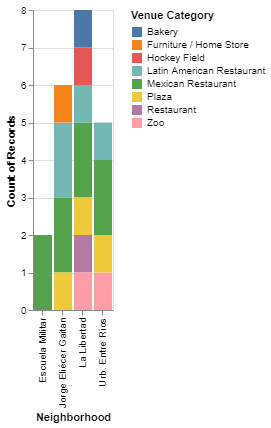

In [94]:
alt.Chart(see_cluster0).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

### In cluster 0 we see that the places near the neighborhoods are mostly living areas such as parks and as well as shopping centers.

# Cluster 1

In [95]:
cluster1 = bogota_merged.loc[bogota_merged['Cluster Labels'] == 1, bogota_merged.columns[[1] + list(range(2, bogota_merged.shape[1]))]]
Neighborhood1 = pd.Series(cluster1['Neighborhood'])
cluster1

,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,San Fernando Occidental,Barrios Unidos,4.674599,-74.081696,1,Cupcake Shop,Restaurant,Burrito Place,Bakery,Pizza Place,Zoo,Fast Food Restaurant,Dance Studio,Deli / Bodega,Department Store
33,Rincón del Salitre - Urb. Modelo II,Barrios Unidos,4.665053,-74.083079,1,Dessert Shop,Pizza Place,Golf Course,Seafood Restaurant,Bakery,Park,Diner,Dog Run,Gym / Fitness Center,South American Restaurant
35,San Fernando Occidental - Urb. Av. Chile,Barrios Unidos,4.672831,-74.081560,1,Pizza Place,Steakhouse,Cupcake Shop,Bakery,Burrito Place,Fried Chicken Joint,Zoo,Electronics Store,Donut Shop,Diner
45,S.C. José Joaquín Vargas,Barrios Unidos,4.669183,-74.086410,1,Pizza Place,Water Park,Dessert Shop,Coffee Shop,Steakhouse,South American Restaurant,Seafood Restaurant,Dog Run,Diner,Department Store
55,Popular Modelo,Barrios Unidos,4.666253,-74.081499,1,Golf Course,Dessert Shop,Pizza Place,Restaurant,Seafood Restaurant,Hot Dog Joint,Bakery,Grocery Store,Fried Chicken Joint,Diner
61,S.C Parque Distrital El Salitre,Barrios Unidos,4.661088,-74.082801,1,Golf Course,Clothing Store,Tennis Court,Soccer Field,Fried Chicken Joint,Diner,Farmers Market,Electronics Store,Donut Shop,Dog Run
62,Club de Empleados Oficiales,Barrios Unidos,4.659166,-74.085364,1,Athletics & Sports,Science Museum,Golf Course,Tennis Court,Park,Zoo,Electronics Store,Donut Shop,Dog Run,Diner
63,Popular Modelo - Urb. Ciudadela de los Parques,Barrios Unidos,4.663386,-74.082351,1,Golf Course,Dessert Shop,Fried Chicken Joint,Clothing Store,Bakery,Park,Seafood Restaurant,Dog Run,Electronics Store,Donut Shop
65,J.J. Vargas - José Joaquín Vargas,Barrios Unidos,4.672654,-74.085337,1,Pizza Place,Department Store,Breakfast Spot,Nightclub,Steakhouse,Coffee Shop,Ice Cream Shop,Cupcake Shop,Burrito Place,Dessert Shop


In [100]:
see_cluster1 = pd.DataFrame(columns = columns)
for i in list(Neighborhood1):
    temp = bogota_venues[bogota_venues['Neighborhood'] == i]
    temp.head()
    see_cluster1 = pd.concat([see_cluster1, temp], axis=0)

see_cluster1['Cluster Labels'] = 0
print(see_cluster1.shape)
see_cluster1.head()

(101, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
64,San Fernando Occidental,4.674599,-74.081696,panaderia astro pan,4.673014,-74.079933,Bakery,0
65,San Fernando Occidental,4.674599,-74.081696,Muffilandia,4.670769,-74.081814,Cupcake Shop,0
66,San Fernando Occidental,4.674599,-74.081696,Ana Gourmet,4.677971,-74.081145,Restaurant,0
67,San Fernando Occidental,4.674599,-74.081696,Tacos Burguer (J. Vargas),4.674546,-74.083853,Burrito Place,0
68,San Fernando Occidental,4.674599,-74.081696,Pizzeto,4.675609,-74.084900,Pizza Place,0


In [97]:
barrios = see_cluster1[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
barrios = barrios.rename(columns={'Neighborhood':'Venue','Neighborhood Latitude':'Venue Latitude','Neighborhood Longitude':'Venue Longitude'})
barrios['Venue Category'] = 0
barrios['Cluster Labels'] = 1
barrios = barrios.groupby('Venue').mean()
barrios = barrios.reset_index()
see_cluster1 = see_cluster1.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
see_cluster1 = pd.concat([see_cluster1, barrios], axis=0, sort=False)
print(see_cluster1.shape)
see_cluster1.head()

(110, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
64,panaderia astro pan,4.673014,-74.079933,Bakery,0
65,Muffilandia,4.670769,-74.081814,Cupcake Shop,0
66,Ana Gourmet,4.677971,-74.081145,Restaurant,0
67,Tacos Burguer (J. Vargas),4.674546,-74.083853,Burrito Place,0
68,Pizzeto,4.675609,-74.084900,Pizza Place,0


In [98]:
map_cluster1 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(see_cluster1['Venue Latitude'], see_cluster1['Venue Longitude'], see_cluster1['Venue'], see_cluster1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster1)
       
map_cluster1

In [99]:
print('There are {} uniques categories.'.format(len(see_cluster0['Venue Category'].unique())))

There are 8 uniques categories.


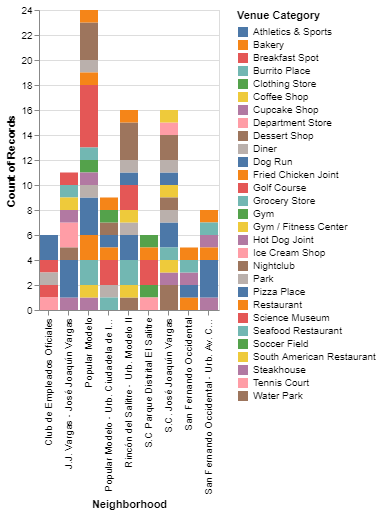

In [101]:
alt.Chart(see_cluster1).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

### Cluster 1, although it has a high number of commercial premises, also highlights social recreation places such as tennis courts, water parks, gyms and soccer fields, shaping up as housing neighborhoods.

# Cluster 2

In [102]:
cluster2 = bogota_merged.loc[bogota_merged['Cluster Labels'] == 2, bogota_merged.columns[[1] + list(range(2, bogota_merged.shape[1]))]]
Neighborhood2 = pd.Series(cluster2['Neighborhood'])
cluster2

,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Siete de Agosto,Barrios Unidos,4.657438,-74.071124,2,Seafood Restaurant,Department Store,Bistro,Fried Chicken Joint,American Restaurant,Deli / Bodega,Café,Fish Market,Market,Auto Workshop
1,La Castellana Occidental,Barrios Unidos,4.686689,-74.062841,2,Restaurant,Fast Food Restaurant,Latin American Restaurant,Theater,Sandwich Place,Steakhouse,Japanese Restaurant,Music Venue,Department Store,Seafood Restaurant
7,Los Andes - Urb. Malta,Barrios Unidos,4.685775,-74.074591,2,Fast Food Restaurant,Burger Joint,Fried Chicken Joint,Sporting Goods Shop,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Shopping Mall,Latin American Restaurant
8,La Castellana - José Maria Carbonel,Barrios Unidos,4.686361,-74.058365,2,Restaurant,Bakery,Hotel,Coffee Shop,Park,Café,Fast Food Restaurant,Breakfast Spot,Latin American Restaurant,Sandwich Place
9,Entrerios,Barrios Unidos,4.681581,-74.075208,2,Gym,Furniture / Home Store,Performing Arts Venue,Public Art,Movie Theater,Juice Bar,Mexican Restaurant,Theater,Garden,German Restaurant
11,Los Andes - Urb. Calle Cien,Barrios Unidos,4.689081,-74.069162,2,Bakery,Bar,Steakhouse,Breakfast Spot,Brewery,Burger Joint,Pub,French Restaurant,Sporting Goods Shop,Sandwich Place
12,Los Andes - Urb. Teusaca,Barrios Unidos,4.686661,-74.072264,2,Burger Joint,Fast Food Restaurant,Sandwich Place,Pizza Place,Shopping Mall,Latin American Restaurant,Sporting Goods Shop,Restaurant,Bakery,Pub
13,Los Andes - Vizcaya III Sector,Barrios Unidos,4.688836,-74.071061,2,Bakery,Sandwich Place,Fast Food Restaurant,Burger Joint,Shopping Mall,Middle Eastern Restaurant,Sporting Goods Shop,Restaurant,Pub,Juice Bar
14,Juan XXIII,Barrios Unidos,4.667326,-74.063602,2,Burger Joint,Public Art,Grocery Store,Bar,Motorcycle Shop,Brewery,Restaurant,Bowling Alley,Donut Shop,Seafood Restaurant
16,Urb. Simón Bolívar,Barrios Unidos,4.681323,-74.078096,2,Fried Chicken Joint,Burger Joint,Sandwich Place,Zoo,BBQ Joint,Performing Arts Venue,Pizza Place,Café,Donut Shop,Breakfast Spot


In [106]:
see_cluster2 = pd.DataFrame(columns = columns)
for i in list(Neighborhood2):
    temp = bogota_venues[bogota_venues['Neighborhood'] == i]
    temp.head()
    see_cluster2 = pd.concat([see_cluster2, temp], axis=0)

see_cluster2['Cluster Labels'] = 0
print(see_cluster2.shape)
see_cluster2.head()

(992, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Siete de Agosto,4.657438,-74.071124,Taperia de la plaza,4.658887,-74.071760,Bistro,0
1,Siete de Agosto,4.657438,-74.071124,Trattoria De La Plaza,4.656679,-74.070045,Bistro,0
2,Siete de Agosto,4.657438,-74.071124,Compania del Sabor,4.659463,-74.069625,Fried Chicken Joint,0
3,Siete de Agosto,4.657438,-74.071124,Las Plazas De Mercado Siete De Agosto,4.657297,-74.070253,Market,0
4,Siete de Agosto,4.657438,-74.071124,"Brisas del Mar, Cevicheria.",4.659428,-74.070114,Seafood Restaurant,0


In [104]:
barrios = see_cluster2[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
barrios = barrios.rename(columns={'Neighborhood':'Venue','Neighborhood Latitude':'Venue Latitude','Neighborhood Longitude':'Venue Longitude'})
barrios['Venue Category'] = 0
barrios['Cluster Labels'] = 1
barrios = barrios.groupby('Venue').mean()
barrios = barrios.reset_index()
see_cluster2 = see_cluster2.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
see_cluster2 = pd.concat([see_cluster2, barrios], axis=0, sort=False)
print(see_cluster2.shape)
see_cluster2.head()

(1037, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,Taperia de la plaza,4.658887,-74.071760,Bistro,0
1,Trattoria De La Plaza,4.656679,-74.070045,Bistro,0
2,Compania del Sabor,4.659463,-74.069625,Fried Chicken Joint,0
3,Las Plazas De Mercado Siete De Agosto,4.657297,-74.070253,Market,0
4,"Brisas del Mar, Cevicheria.",4.659428,-74.070114,Seafood Restaurant,0


In [105]:
map_cluster2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(see_cluster2['Venue Latitude'], see_cluster2['Venue Longitude'], see_cluster2['Venue'], see_cluster2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster2)
       
map_cluster2

In [107]:
print('There are {} uniques categories.'.format(len(see_cluster2['Venue Category'].unique())))

There are 113 uniques categories.


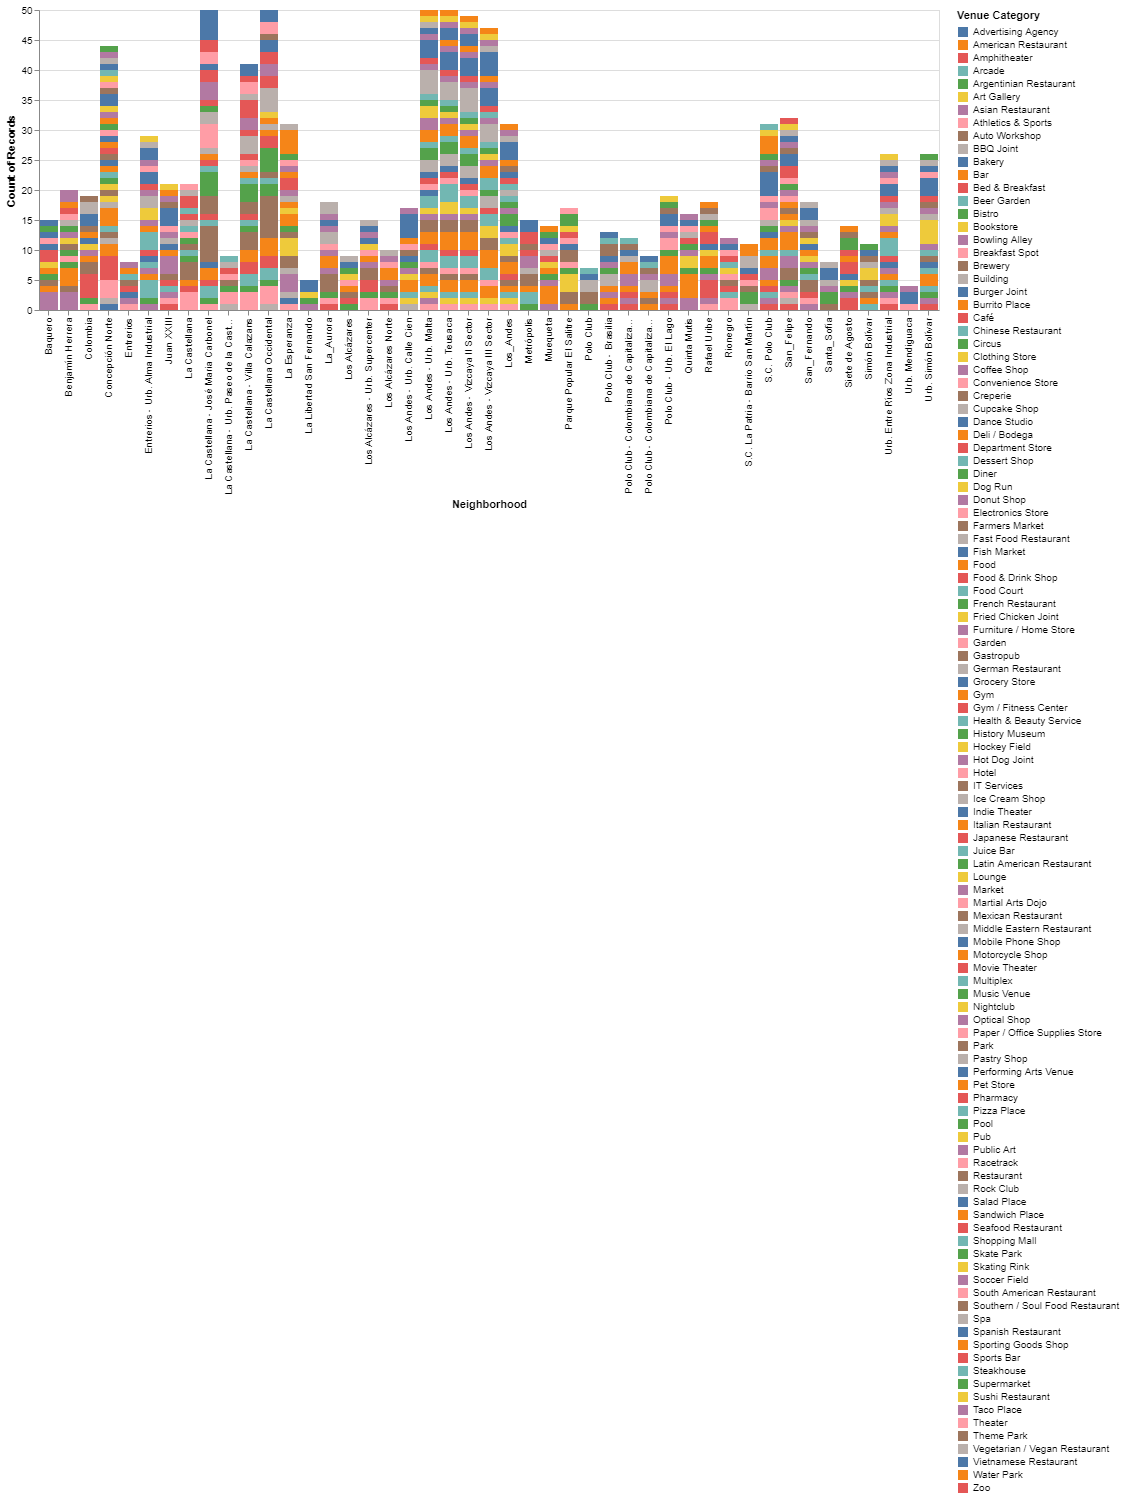

In [108]:
alt.Chart(see_cluster2).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

### In cluster 2, soccer fields, golf courses, parking lots, motorcycle shops, hotels among others stand out, which suggests that this is a semi-industrial zone.

# Cluster 3

In [109]:
cluster3 = bogota_merged.loc[bogota_merged['Cluster Labels'] == 3, bogota_merged.columns[[1] + list(range(2, bogota_merged.shape[1]))]]
Neighborhood3 = pd.Series(cluster3['Neighborhood'])
cluster3

,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,11 de Noviembre,Barrios Unidos,4.668293,-74.070911,3,Fast Food Restaurant,BBQ Joint,Furniture / Home Store,Latin American Restaurant,Motorcycle Shop,Farmers Market,Market,Donut Shop,South American Restaurant,Restaurant
4,12 de Octubre,Barrios Unidos,4.669843,-74.074384,3,Fast Food Restaurant,Furniture / Home Store,BBQ Joint,Farmers Market,Donut Shop,Latin American Restaurant,South American Restaurant,Restaurant,Dessert Shop,Fish Market
6,La Merced Norte,Barrios Unidos,4.664913,-74.073638,3,Fast Food Restaurant,South American Restaurant,Donut Shop,Farmers Market,BBQ Joint,Latin American Restaurant,Soccer Field,Fish Market,Electronics Store,Dog Run
24,12 de Octubre - Alcabaza,Barrios Unidos,4.672028,-74.075281,3,Furniture / Home Store,Hockey Field,Restaurant,Farmers Market,Fast Food Restaurant,BBQ Joint,Latin American Restaurant,South American Restaurant,Garden,Gastropub
38,Urb. Santa Mónica,Barrios Unidos,4.670128,-74.070891,3,BBQ Joint,Furniture / Home Store,South American Restaurant,Restaurant,Farmers Market,Latin American Restaurant,Fast Food Restaurant,Dessert Shop,Fish Market,Department Store


In [116]:
see_cluster3 = pd.DataFrame(columns = columns)
for i in list(Neighborhood3):
    temp = bogota_venues[bogota_venues['Neighborhood'] == i]
    temp.head()
    see_cluster3 = pd.concat([see_cluster3, temp], axis=0)

see_cluster3['Cluster Labels'] = 0
print(see_cluster3.shape)
see_cluster3.head()

(53, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
69,11 de Noviembre,4.668293,-74.070911,Asadero La Carnecita A La Brasa,4.671098,-74.068701,Restaurant,0
70,11 de Noviembre,4.668293,-74.070911,Mi gran parrilla boyacense,4.666876,-74.074849,Latin American Restaurant,0
71,11 de Noviembre,4.668293,-74.070911,sr. pig,4.669666,-74.073006,BBQ Joint,0
72,11 de Noviembre,4.668293,-74.070911,La Ternera Parrilla,4.667553,-74.074638,BBQ Joint,0
73,11 de Noviembre,4.668293,-74.070911,Chopinar,4.665968,-74.074416,Fast Food Restaurant,0


In [115]:
barrios = see_cluster3[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
barrios = barrios.rename(columns={'Neighborhood':'Venue','Neighborhood Latitude':'Venue Latitude','Neighborhood Longitude':'Venue Longitude'})
barrios['Venue Category'] = 0
barrios['Cluster Labels'] = 1
barrios = barrios.groupby('Venue').mean()
barrios = barrios.reset_index()
see_cluster3 = see_cluster3.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
see_cluster3 = pd.concat([see_cluster3, barrios], axis=0, sort=False)
print(see_cluster3.shape)
see_cluster3.head()

(58, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
69,Asadero La Carnecita A La Brasa,4.671098,-74.068701,Restaurant,0
70,Mi gran parrilla boyacense,4.666876,-74.074849,Latin American Restaurant,0
71,sr. pig,4.669666,-74.073006,BBQ Joint,0
72,La Ternera Parrilla,4.667553,-74.074638,BBQ Joint,0
73,Chopinar,4.665968,-74.074416,Fast Food Restaurant,0


In [112]:
map_cluster3 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(see_cluster3['Venue Latitude'], see_cluster3['Venue Longitude'], see_cluster3['Venue'], see_cluster3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster3)
       
map_cluster3

In [117]:
print('There are {} uniques categories.'.format(len(see_cluster3['Venue Category'].unique())))

There are 12 uniques categories.


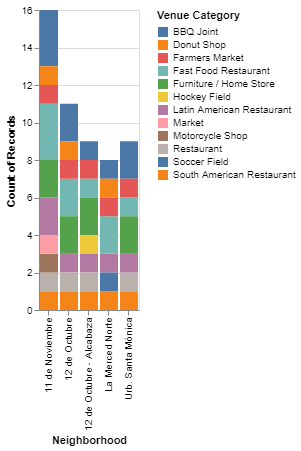

In [118]:
alt.Chart(see_cluster3).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

### In cluster 3 we see that it is a small commercial area located in the heart of the town, which would be a good option for our store since in the categories there is no place of coffee.

# Cluster 4

In [119]:
cluster4 = bogota_merged.loc[bogota_merged['Cluster Labels'] == 4, bogota_merged.columns[[1] + list(range(2, bogota_merged.shape[1]))]]
Neighborhood4 = pd.Series(cluster4['Neighborhood'])
cluster4

,Neighborhood,Localidad,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,La Paz,Barrios Unidos,4.659441,-74.075052,4,Soccer Field,Park,Diner,Auto Garage,Bistro,Zoo,Fish Market,Dance Studio,Deli / Bodega,Department Store
44,El Rosario,Barrios Unidos,4.655076,-74.080826,4,Soccer Field,Bowling Alley,Park,Fried Chicken Joint,Donut Shop,BBQ Joint,Diner,Pool,Gastropub,Hotel
54,San Miguel_,Barrios Unidos,4.661749,-74.078415,4,Soccer Field,Auto Garage,Clothing Store,Fried Chicken Joint,Astrologer,Fish Market,Fast Food Restaurant,Farmers Market,Electronics Store,Donut Shop


In [124]:
see_cluster4 = pd.DataFrame(columns = columns)
for i in list(Neighborhood4):
    temp = bogota_venues[bogota_venues['Neighborhood'] == i]
    temp.head()
    see_cluster4 = pd.concat([see_cluster4, temp], axis=0)

see_cluster4['Cluster Labels'] = 0
print(see_cluster4.shape)
see_cluster4.head()

(30, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
96,La Paz,4.659441,-74.075052,Taperia de la plaza,4.658887,-74.071760,Bistro,0
97,La Paz,4.659441,-74.075052,Dimension Bike Store,4.658954,-74.076031,Auto Garage,0
98,La Paz,4.659441,-74.075052,Parque El Lago,4.656584,-74.076910,Park,0
99,La Paz,4.659441,-74.075052,Lechoneria Tolimense Doña Resu,4.655585,-74.076537,Diner,0
100,La Paz,4.659441,-74.075052,La pecosa,4.662711,-74.077229,Soccer Field,0


In [121]:
barrios = see_cluster4[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
barrios = barrios.rename(columns={'Neighborhood':'Venue','Neighborhood Latitude':'Venue Latitude','Neighborhood Longitude':'Venue Longitude'})
barrios['Venue Category'] = 0
barrios['Cluster Labels'] = 1
barrios = barrios.groupby('Venue').mean()
barrios = barrios.reset_index()
see_cluster4 = see_cluster4.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], axis=1)
see_cluster4 = pd.concat([see_cluster4, barrios], axis=0, sort=False)
print(see_cluster4.shape)
see_cluster4.head()

(33, 5)


,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
96,Taperia de la plaza,4.658887,-74.071760,Bistro,0
97,Dimension Bike Store,4.658954,-74.076031,Auto Garage,0
98,Parque El Lago,4.656584,-74.076910,Park,0
99,Lechoneria Tolimense Doña Resu,4.655585,-74.076537,Diner,0
100,La pecosa,4.662711,-74.077229,Soccer Field,0


In [122]:
map_cluster4 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(see_cluster4['Venue Latitude'], see_cluster4['Venue Longitude'], see_cluster4['Venue'], see_cluster4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster4)
       
map_cluster4

In [123]:
print('There are {} uniques categories.'.format(len(see_cluster4['Venue Category'].unique())))

There are 16 uniques categories.


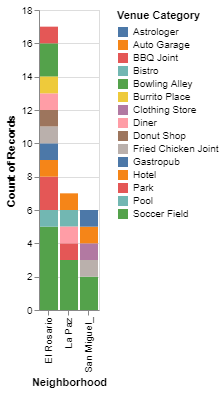

In [125]:
alt.Chart(see_cluster4).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

### The places that make up this group are bowling alleys, soccer fields, parks, swimming pools and garages, this indicates that it can be a warehouse area, so we will discard this cluster for our search.

#### From the analysis made of the clusters it follows:
Clusters 2 and 3 will be used to locate our workplace since among the others they were the ones with the greatest concentration of businesses.

Clusters 0 and 1 will be used to find our place of housing.

## We filter out of clusters those neighborhoods that already have places where they sell coffee

In [156]:
place_no_coffee = pd.concat([see_cluster2, see_cluster3], axis=0)
print(place_no_coffee.shape)
lista = place_no_coffee.iloc[:,6]
barrios = place_no_coffee
count = 0
for i in list(lista):
    if i == "Café"  or i == "Coffee Shop" :
        barrio = barrios.iloc[count,0]
        place_no_coffee = place_no_coffee[place_no_coffee['Neighborhood'] != barrio]
    count += 1

print(place_no_coffee.shape)
place_no_coffee.head()

(1045, 8)
(385, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
211,Entrerios,4.681581,-74.075208,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
212,Entrerios,4.681581,-74.075208,Teatro Cafam de Bellas Artes,4.684871,-74.073179,Theater,0
213,Entrerios,4.681581,-74.075208,Bodytech,4.685493,-74.073698,Gym,0
214,Entrerios,4.681581,-74.075208,Tugó,4.684690,-74.077986,Furniture / Home Store,0
215,Entrerios,4.681581,-74.075208,Hangar Films,4.683527,-74.077027,Performing Arts Venue,0


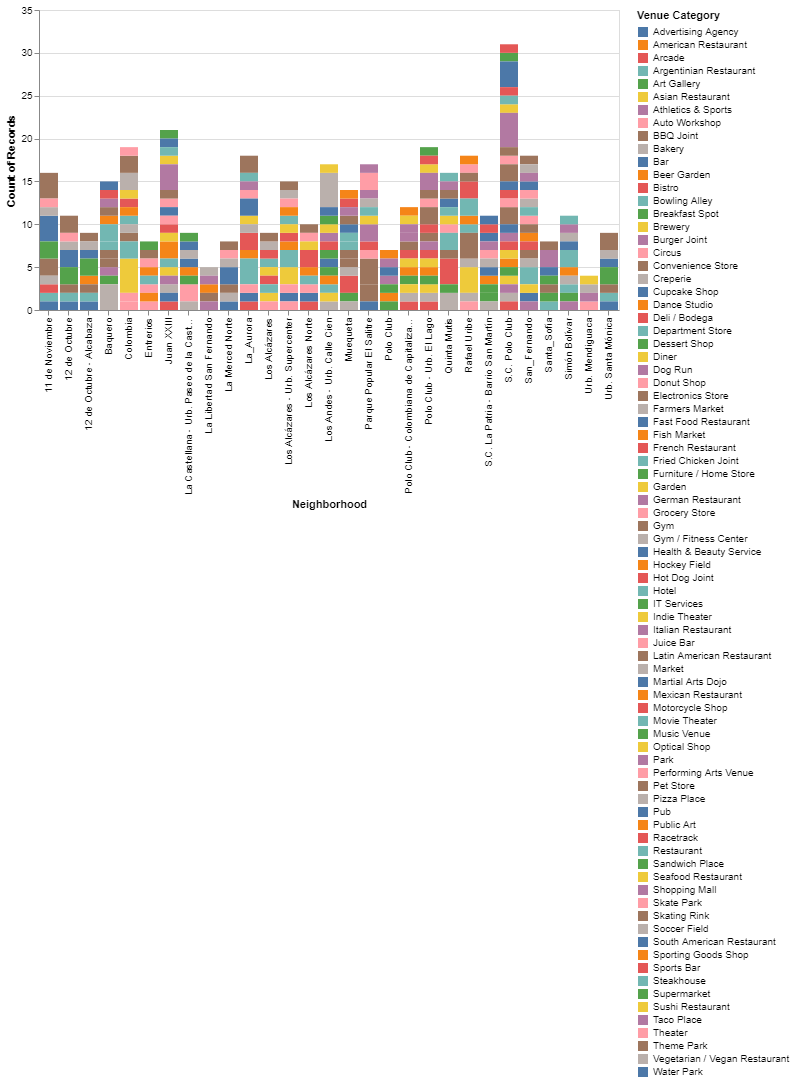

In [133]:
alt.Chart(place_no_coffee).mark_bar().encode(
    x='Neighborhood',
    y='count(Venue Category)',
    color='Venue Category'
)

In [136]:
place_work = place_no_coffee[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
place_work = place_work.groupby('Neighborhood').mean()
place_work = place_work.reset_index()
print('Total neighborhoods that do not have coffee shops: ',len(place_work))

Total neighborhoods that do not have coffee shops:  29


In [141]:
print('Shape cluster 0: ' , see_cluster0.shape)
print('Shape cluster 1: ' , see_cluster1.shape)
place_home = pd.concat([see_cluster0, see_cluster1], axis=0)
print('New df union clusters 0 and 1: ' , place_home.shape)
place_home.head()

Shape cluster 0:  (21, 8)
Shape cluster 1:  (101, 8)
New df union clusters 0 and 1:  (122, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
219,Escuela Militar,4.679628,-74.070552,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
220,Escuela Militar,4.679628,-74.070552,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
356,Jorge Eliécer Gaitan,4.674671,-74.072090,Los Cuates,4.676521,-74.072914,Mexican Restaurant,0
357,Jorge Eliécer Gaitan,4.674671,-74.072090,Taquería Mi Lupe,4.677687,-74.073847,Mexican Restaurant,0
358,Jorge Eliécer Gaitan,4.674671,-74.072090,El Comedor,4.676461,-74.074671,Latin American Restaurant,0


We exclude places that are parks, clubs and military zones

In [142]:
place_home = place_home[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
place_home = place_home.groupby('Neighborhood').mean()
place_home = place_home.drop(['Club de Empleados Oficiales','Escuela Militar','S.C Parque Distrital El Salitre'], axis=0)
place_home = place_home.reset_index()
print('Total neighborhoods as possible homes: ', len(place_home))

Total neighborhoods as possible homes:  10


#### We calculate the geodetic distances between the housing neighborhoods and the commercial neighborhoods.

In [143]:
distance_home_work = pd.DataFrame(columns=[0,1,2])
for i in range(len(place_home)):
    geo_home = place_home.loc[i,'Neighborhood Latitude':'Neighborhood Longitude']
    name_home = place_home.loc[i, 'Neighborhood']
    for j in range(len(place_work)):
        geo_work = place_work.loc[j,'Neighborhood Latitude':'Neighborhood Longitude']
        name_work = place_work.loc[j, 'Neighborhood']
        distance = round(vincenty_inverse([geo_home[0],geo_home[1]],[geo_work[0],geo_work[1]]).m, 2)
        
        temp = pd.DataFrame([name_home,name_work,distance]).T
        
        distance_home_work = pd.concat([distance_home_work, temp], axis=0)

distance_home_work = distance_home_work.rename(columns={0:'name_home', 1:'name_work', 2:'distance'}).reset_index().drop(['index'], axis=1)        
print(distance_home_work.shape)
distance_home_work.head()

(290, 3)


,name_home,name_work,distance
0,J.J. Vargas - José Joaquín Vargas,11 de Noviembre,1671.73
1,J.J. Vargas - José Joaquín Vargas,12 de Octubre,1254.4
2,J.J. Vargas - José Joaquín Vargas,12 de Octubre - Alcabaza,1117.89
3,J.J. Vargas - José Joaquín Vargas,Baquero,2910.2
4,J.J. Vargas - José Joaquín Vargas,Colombia,2539.98


#### We filter those neighborhoods that have a distance of less than a kilometer of travel distance between possible housing and work points

In [144]:
places = distance_home_work[distance_home_work['distance'] < 1000]
places.shape

(51, 3)

In [145]:
lista_home = places.groupby('name_home').count()
lista_home = lista_home.reset_index()
lista_home = lista_home['name_home']

lista_work = places.groupby('name_work').count()
lista_work = lista_work.reset_index()
lista_work = lista_work['name_work']


In [150]:
points_home = pd.DataFrame(columns=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])
for i in list(lista_home):
    
    temp = place_home[place_home['Neighborhood'] == i]
    points_home = pd.concat([points_home, temp], axis=0)

points_home['mark'] = 2 

In [151]:
points_work = pd.DataFrame(columns=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])
for i in list(lista_work):

    temp = place_work[place_work['Neighborhood'] == i]
    points_work = pd.concat([points_work, temp])

points_work['mark'] = 0

In [152]:
final_points = pd.concat([points_home, points_work], axis=0)
print(final_points.shape)
final_points

(24, 4)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,mark
0,J.J. Vargas - José Joaquín Vargas,4.672654,-74.085337,2
1,Jorge Eliécer Gaitan,4.674671,-74.072090,2
2,La Libertad,4.676235,-74.077267,2
3,Popular Modelo,4.666253,-74.081499,2
4,Popular Modelo - Urb. Ciudadela de los Parques,4.663386,-74.082351,2
5,Rincón del Salitre - Urb. Modelo II,4.665053,-74.083079,2
6,S.C. José Joaquín Vargas,4.669183,-74.086410,2
7,San Fernando Occidental,4.674599,-74.081696,2
8,San Fernando Occidental - Urb. Av. Chile,4.672831,-74.081560,2
9,Urb. Entre Ríos,4.679062,-74.075999,2


### Finally, we mark on the blue map those neighborhoods that are possible housing points and in red those that are commercial areas.

In [153]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_points['Neighborhood Latitude'], final_points['Neighborhood Longitude'], final_points['Neighborhood'], final_points['mark']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

During the process, a closterization algorithm was implemented, finding 5 groups with different trends regarding the density of places and types of shops, we proceeded to join cluster 1 and 3 to have a total of 1039 establishments, this concentration of commercial premises indicates that the flow of people is high which in theory can improve the demand for our product, we cover a radius of 500 meters to find the largest amount of our target business in this case the coffee shops and thus make sure we have the places that are possibly more isolated within the mass of points.

The neighborhoods with fewer commercial establishments had characteristics such as being near parks, cinemas, squares, theaters, schools and shopping centers, of course this scenario was presented as a good option to locate our home, those clusters with this trend were the 0 and 4.

Finally, the distances between the neighborhoods of the clusters with high commerce and those classified as housing options have been calculated, the distances between these two types of places were filtered, taking as a criterion that a person travels 5 km on foot in 60 minutes it was decided Find the places that will be less than 15 minutes away which gives us an approximate one kilometer between them, we have 25 places distributed in 11 housing districts and 14 commercial districts, in this way we concentrate our efforts on locating those 2 points that reduce our journey time between our home and our workplace.

The purpose of this analysis was to find a practical way to reduce the time we spend on city traffic or in the best case avoid it, it is important to note that the “last mile” of this result would be based on going to the points which we determine as our best option, thanks to technology we can make a virtual visit to two of these places that in my opinion are good options.

Housing point

https://www.google.com/maps/@4.674412,-74.0721533.3a.75y.237.47h.92.78t/data=!3m6!1e1!3m4!1syPCgfN_T7JHALjeu3y1oDA!2e0!7i13312!8i6656

Trading point

https://www.google.com/maps/@4.6703408,-74.0729676,3a,75y,32.43h,102.34t/data=!3m6!1e1!3m4!1sXSXGtGGfZtANo1vqH3jt-w!2e0!7i13312!8i6656

## Conclusion <a name="conclusion"></a>

Although the objective of this analysis was simply to try to reduce or, at best, avoid traffic during the movement between housing and work in one of the cities considered to have a high mobility deficit, several analyzes had to be done that indirectly They were taking us to the goal.

 The problem can be addressed in many other ways such as those who already have an established workplace and only wish to find a better housing option, also those who are in a state of vulnerability such as disabled people, older adults or head-of-home mothers who, due to their situation, are the ones who should undertake the most because societies tend to segregate them solely because of their social status, this application can improve their living conditions by reducing travel time and in turn assuring them the best place to develop Your commercial activity.
 
Although the information collected thanks to the Foursquare API was sufficient in this case, it can be further enriched by making use of data such as the value of leases in different locations since the different social strata that are distributed over the territory largely determine the cost of living in each sector, finally the interested person will make the decision based on their personal tastes, the characteristics of the neighborhoods, social and economic dynamics, this application will provide a much clearer picture about this issue.